In [ ]:
!tar -xzvf /content/hwu.tar.gz

In [ ]:
!pip install gensim
!pip install tensorflow

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss

from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

# Utils

In [29]:
def visualize_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_normalized = np.divide(cm, cm_sum, where=cm_sum != 0)  # tránh chia 0

    plt.figure(figsize=(30, 24))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={"label": "Tỷ lệ (%)"}
    )

    plt.xlabel("Dự đoán", fontsize=13)
    plt.ylabel("Thực tế", fontsize=13)
    plt.xticks(rotation=45, ha="right", fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    plt.show()

# Data preprocessing

In [30]:
df_train = pd.read_csv('/content/hwu/train.csv')
df_val = pd.read_csv('/content/hwu/val.csv')
df_test = pd.read_csv('/content/hwu/test.csv')
print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (8954, 2)
Validation shape: (1076, 2)
Test shape: (1076, 2)


,text,category
0,what alarms do i have set right now,alarm_query
1,checkout today alarm of meeting,alarm_query
2,report alarm settings,alarm_query
3,see see for me the alarms that you have set to...,alarm_query
4,is there an alarm for ten am,alarm_query


In [31]:
label_enc = LabelEncoder()
df_train['intent'] = label_enc.fit_transform(df_train['category'])
df_val['intent'] = label_enc.transform(df_val['category'])
df_test['intent'] = label_enc.transform(df_test['category'])
df_train.head()

,text,category,intent
0,what alarms do i have set right now,alarm_query,0
1,checkout today alarm of meeting,alarm_query,0
2,report alarm settings,alarm_query,0
3,see see for me the alarms that you have set to...,alarm_query,0
4,is there an alarm for ten am,alarm_query,0


# TF-IDF + Logistic Regression

In [32]:
tfidf_lr_pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000)
)
tfidf_lr_pipeline.fit(df_train['text'], df_train['intent'])

test_probas = tfidf_lr_pipeline.predict_proba(df_test['text'])
test_loss = log_loss(df_test['intent'], test_probas)
print(f"Test Loss: {test_loss:.4f}")

pred = tfidf_lr_pipeline.predict(df_test['text'])
print(classification_report(df_test['intent'], pred, target_names=label_enc.classes_))

Test Loss: 1.0502
                          precision    recall  f1-score   support

             alarm_query       0.90      0.95      0.92        19
            alarm_remove       1.00      0.73      0.84        11
               alarm_set       0.77      0.89      0.83        19
       audio_volume_down       1.00      0.75      0.86         8
       audio_volume_mute       0.92      0.80      0.86        15
         audio_volume_up       0.93      1.00      0.96        13
          calendar_query       0.45      0.53      0.49        19
         calendar_remove       0.89      0.89      0.89        19
            calendar_set       0.87      0.68      0.76        19
          cooking_recipe       0.59      0.68      0.63        19
        datetime_convert       0.67      0.75      0.71         8
          datetime_query       0.74      0.89      0.81        19
        email_addcontact       0.78      0.88      0.82         8
             email_query       0.83      0.79      0.81  

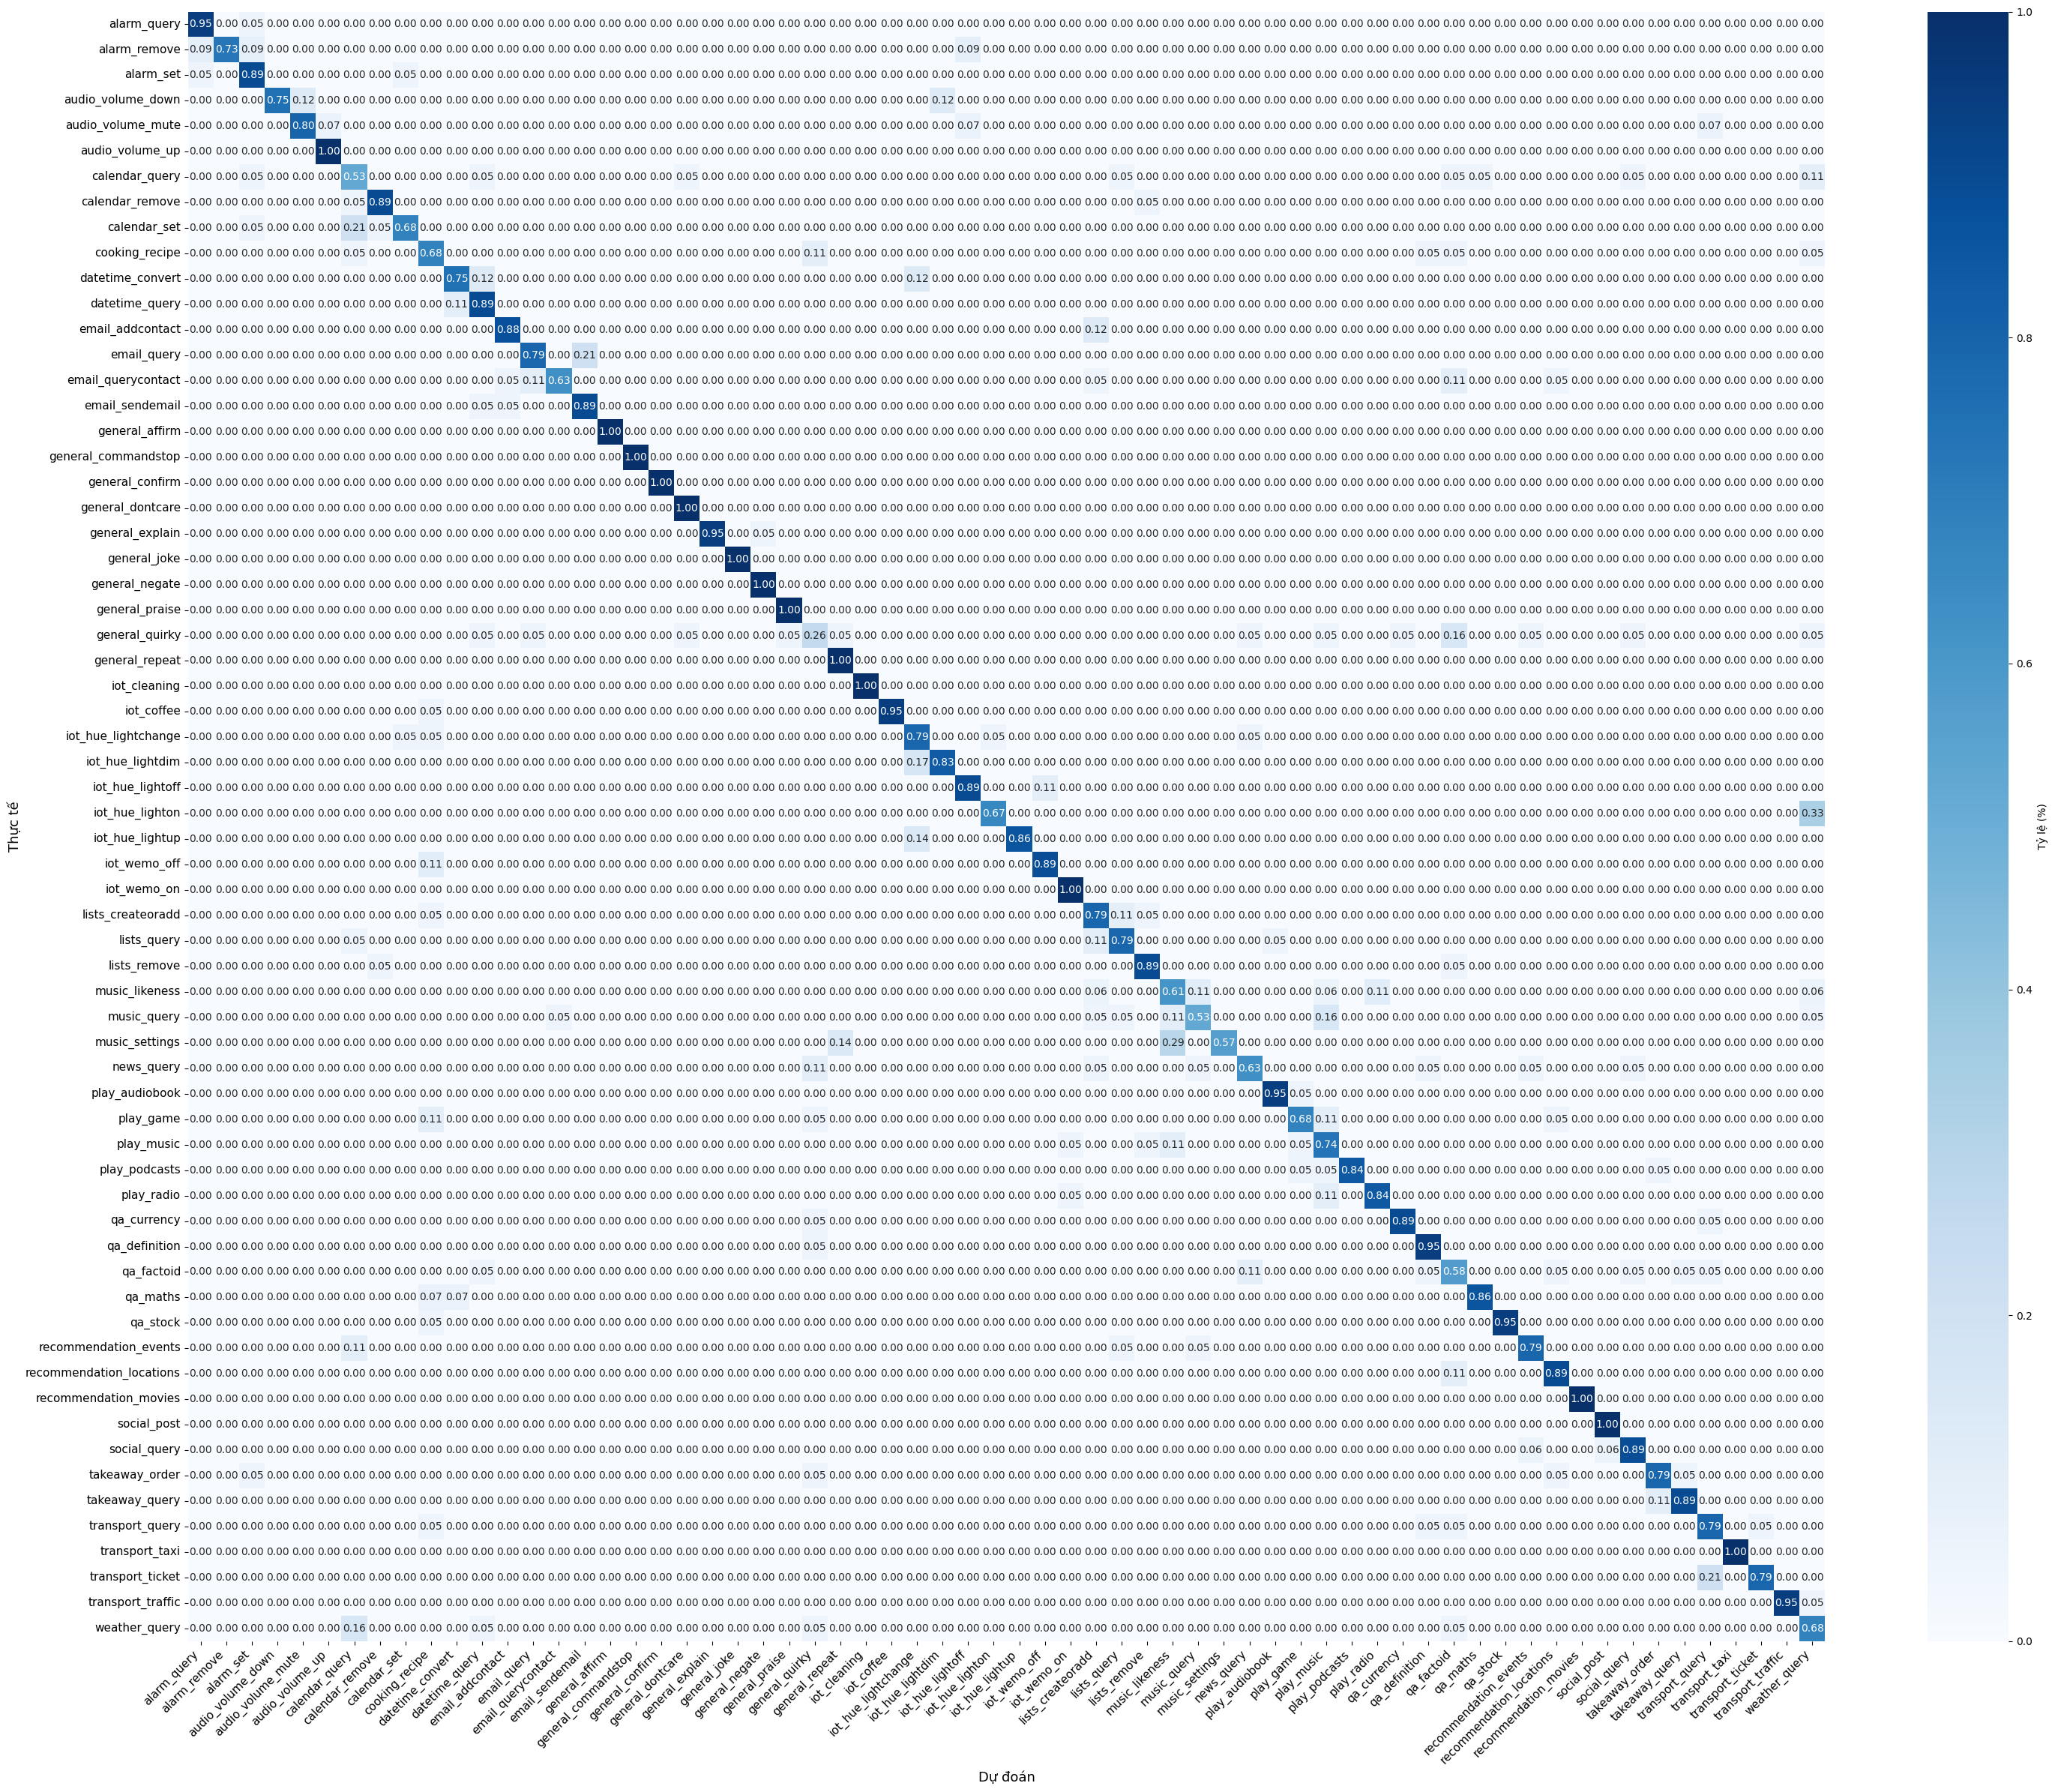

In [33]:
visualize_confusion_matrix(df_test['intent'], pred, label_enc.classes_)

# Word2Vec + Dense Layer

In [34]:
def sentence_to_avg_vector(text, model):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [ ]:
sentences = [text.split() for text in df_train['text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

X_train_avg = np.array([sentence_to_avg_vector(sentence, w2v_model) for sentence in df_train['text']])
X_val_avg = np.array([sentence_to_avg_vector(sentence, w2v_model) for sentence in df_val['text']])
X_test_avg = np.array([sentence_to_avg_vector(sentence, w2v_model) for sentence in df_test['text']])
print(X_train_avg[0])

In [36]:
model = Sequential([
    Input(shape=(w2v_model.vector_size,)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_enc.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,184 (82.75 KB)

 Trainable params: 21,184 (82.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with tf.device('/GPU:0'):  # ép chạy trên GPU nếu có
    history = model.fit(
        X_train_avg, df_train['intent'],
        validation_data=(X_val_avg, df_val['intent']),
        epochs=500,
        batch_size=16,
        verbose=1
    )

In [38]:
test_results = model.evaluate(
    X_test_avg,
    df_test['intent'],
    verbose=0
)
test_loss = test_results[0]
test_accuracy = test_results[1]
print(f"Test Loss: {test_loss:.4f}")

y_pred = np.argmax(model.predict(X_test_avg), axis=1)
print(classification_report(df_test['intent'], y_pred, target_names=label_enc.classes_))

Test Loss: 1.9769
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                          precision    recall  f1-score   support

             alarm_query       0.64      0.74      0.68        19
            alarm_remove       0.67      0.36      0.47        11
               alarm_set       0.65      0.89      0.76        19
       audio_volume_down       0.50      0.25      0.33         8
       audio_volume_mute       0.20      0.13      0.16        15
         audio_volume_up       0.44      0.62      0.52        13
          calendar_query       0.29      0.11      0.15        19
         calendar_remove       0.57      0.63      0.60        19
            calendar_set       0.22      0.32      0.26        19
          cooking_recipe       0.30      0.16      0.21        19
        datetime_convert       0.75      0.38      0.50         8
          datetime_query       0.36      0.53      0.43        19
        email_addcontact       0.62      1.00      0.76         8
             email

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


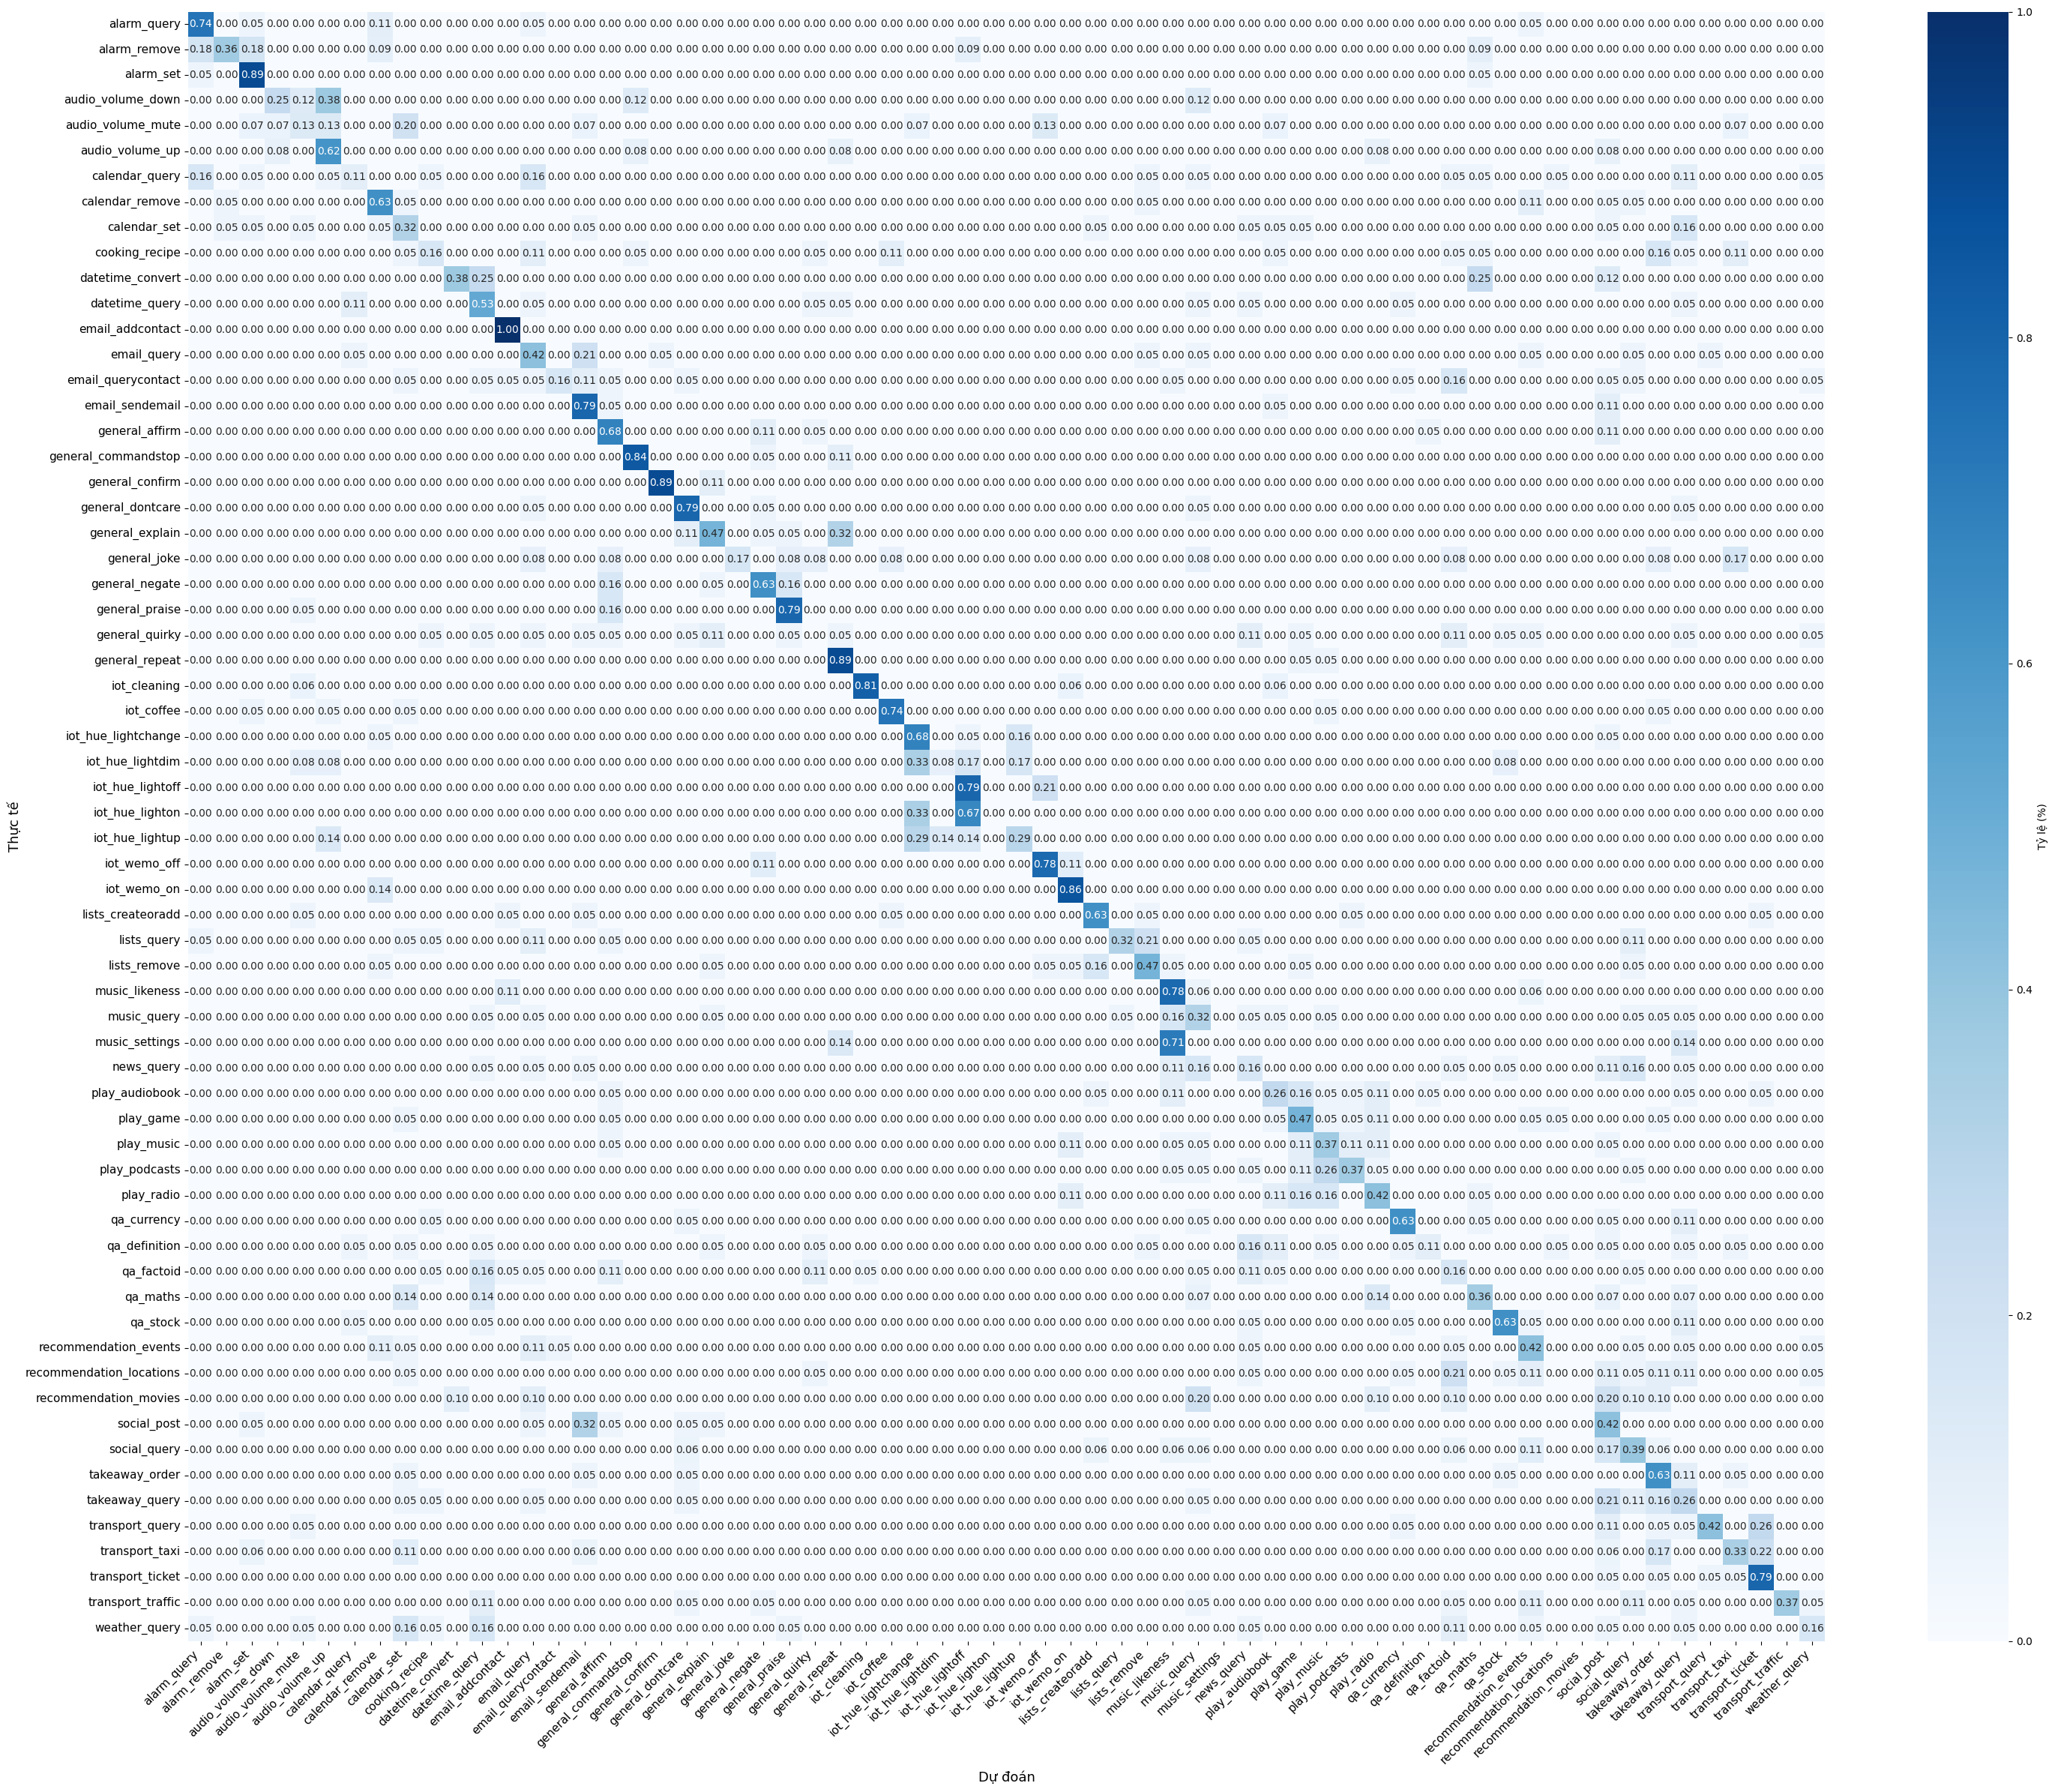

In [39]:
visualize_confusion_matrix(df_test['intent'], y_pred, label_enc.classes_)

# Embedding Pretrained + LSTM

In [40]:
vocab_size = 10000
max_len = 50

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tokenizer.fit_on_texts(df_train['text'])

train_sequences = tokenizer.texts_to_sequences(df_train['text'])
val_sequences = tokenizer.texts_to_sequences(df_val['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

X_train_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(val_sequences, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post')

In [41]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

lstm_model_pretrained = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix], # Khởi tạo trọng số
        input_length=max_len,
        trainable=False # Đóng băng lớp Embedding
    ),
    LSTM(128, dropout=0.2, recurrent_dropout=0.0),
    Dense(len(label_enc.classes_), activation='softmax')
])

lstm_model_pretrained.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model_pretrained.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       426,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,500 (1.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 426,500 (1.63 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

with tf.device('/GPU:0'):  # ép chạy trên GPU nếu có
    history = lstm_model_pretrained.fit(
        X_train_pad, df_train['intent'],
        validation_data=(X_val_pad, df_val['intent']),
        epochs=500,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )

In [43]:
test_results = lstm_model_pretrained.evaluate(
    X_test_pad,
    df_test['intent'],
    verbose=0
)
test_loss = test_results[0]
test_accuracy = test_results[1]
print(f"Test Loss: {test_loss:.4f}")

y_pred = np.argmax(lstm_model_pretrained.predict(X_test_pad), axis=1)
print(classification_report(df_test['intent'], y_pred, target_names=label_enc.classes_))

Test Loss: 2.7085
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
                          precision    recall  f1-score   support

             alarm_query       0.69      0.58      0.63        19
            alarm_remove       0.55      0.55      0.55        11
               alarm_set       0.68      0.79      0.73        19
       audio_volume_down       1.00      0.12      0.22         8
       audio_volume_mute       0.50      0.13      0.21        15
         audio_volume_up       0.29      0.38      0.33        13
          calendar_query       0.21      0.21      0.21        19
         calendar_remove       0.22      0.11      0.14        19
            calendar_set       0.15      0.32      0.20        19
          cooking_recipe       0.00      0.00      0.00        19
        datetime_convert       0.00      0.00      0.00         8
          datetime_query       0.24      0.42      0.30        19
        email_addcontact       0.00      0.00      0.00         8
             email

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


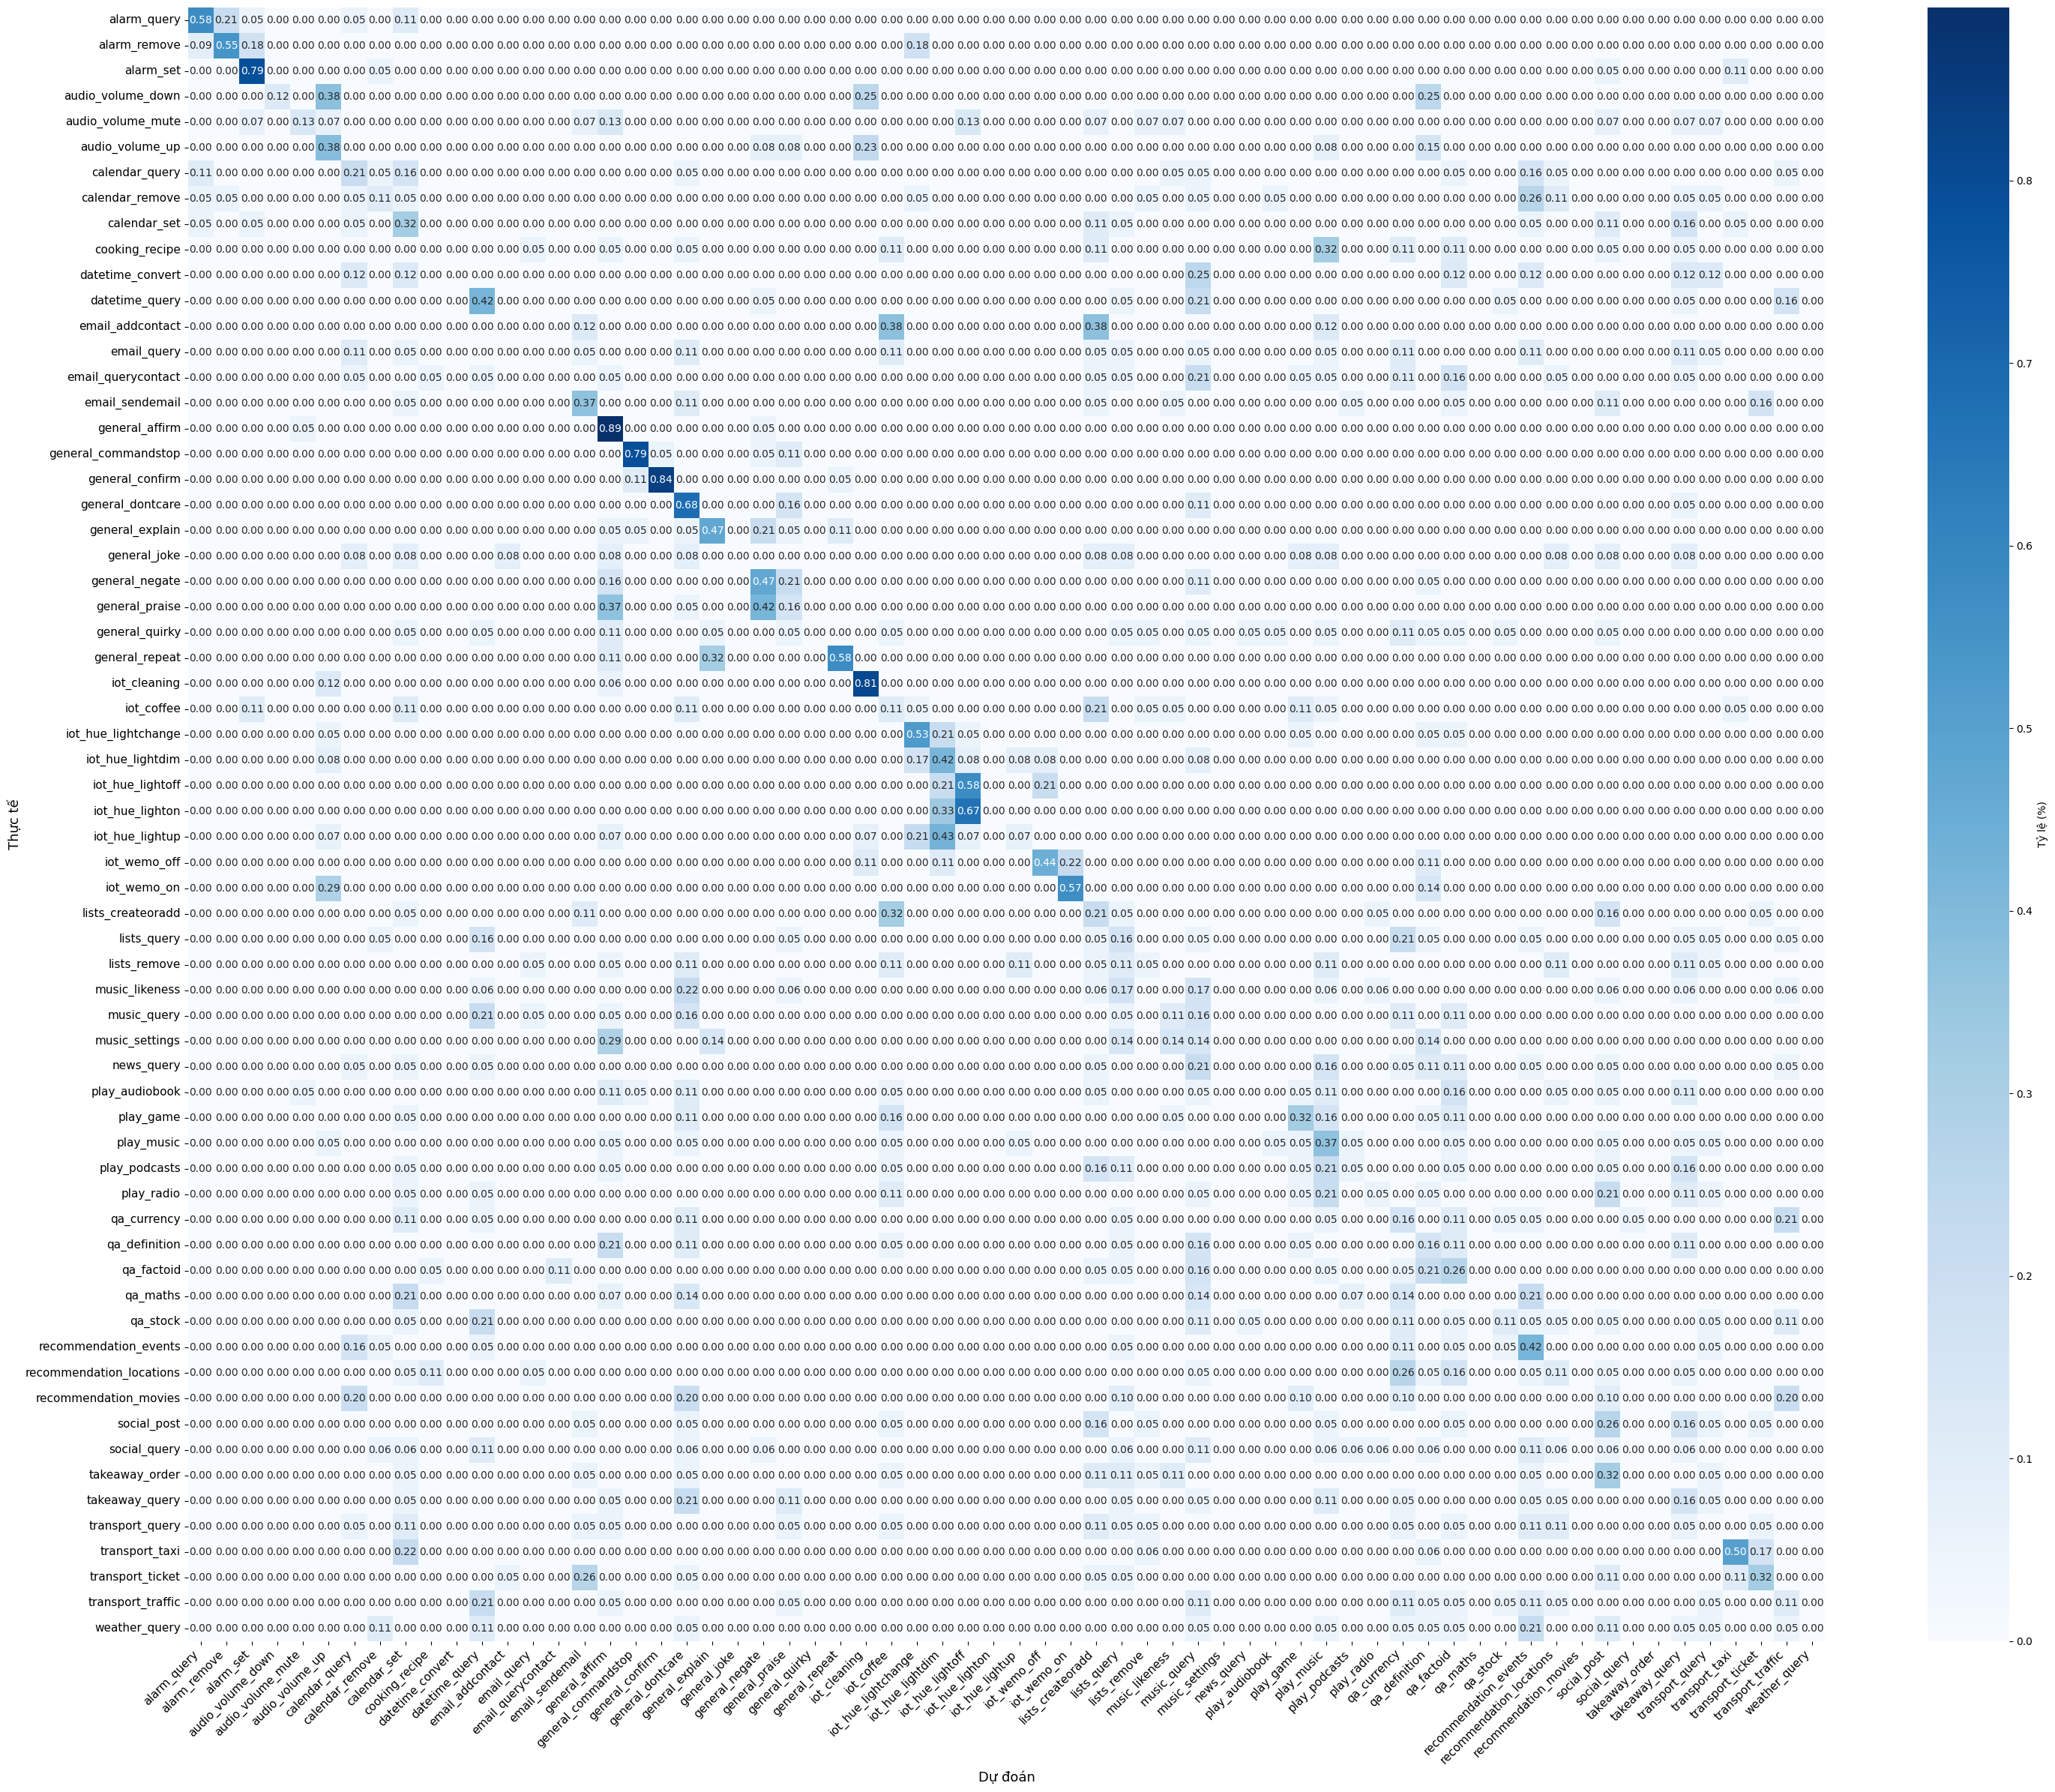

In [44]:
visualize_confusion_matrix(df_test['intent'], y_pred, label_enc.classes_)

# Embedding + LSTM

In [45]:
lstm_model_scratch = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=100, # Chọn một chiều embedding, ví dụ 100
        input_length=max_len
    ),
    LSTM(128, dropout=0.2, recurrent_dropout=0.0),
    Dense(len(label_enc.classes_), activation='softmax')
])

lstm_model_scratch.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model_scratch.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

with tf.device('/GPU:0'):  # ép chạy trên GPU nếu có
    history = lstm_model_scratch.fit(
        X_train_pad, df_train['intent'],
        validation_data=(X_val_pad, df_val['intent']),
        epochs=500,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )

In [47]:
test_results = lstm_model_scratch.evaluate(
    X_test_pad,
    df_test['intent'],
    verbose=0
)
test_loss = test_results[0]
test_accuracy = test_results[1]
print(f"Test Loss: {test_loss:.4f}")

y_pred = np.argmax(lstm_model_scratch.predict(X_test_pad), axis=1)
print(classification_report(df_test['intent'], y_pred, target_names=label_enc.classes_))

Test Loss: 4.1236
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                          precision    recall  f1-score   support

             alarm_query       0.00      0.00      0.00        19
            alarm_remove       0.00      0.00      0.00        11
               alarm_set       0.00      0.00      0.00        19
       audio_volume_down       0.00      0.00      0.00         8
       audio_volume_mute       0.00      0.00      0.00        15
         audio_volume_up       0.00      0.00      0.00        13
          calendar_query       0.00      0.00      0.00        19
         calendar_remove       0.00      0.00      0.00        19
            calendar_set       0.00      0.00      0.00        19
          cooking_recipe       0.00      0.00      0.00        19
        datetime_convert       0.00      0.00      0.00         8
          datetime_query       0.00      0.00      0.00        19
        email_addcontact       0.00      0.00      0.00         8
             email

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


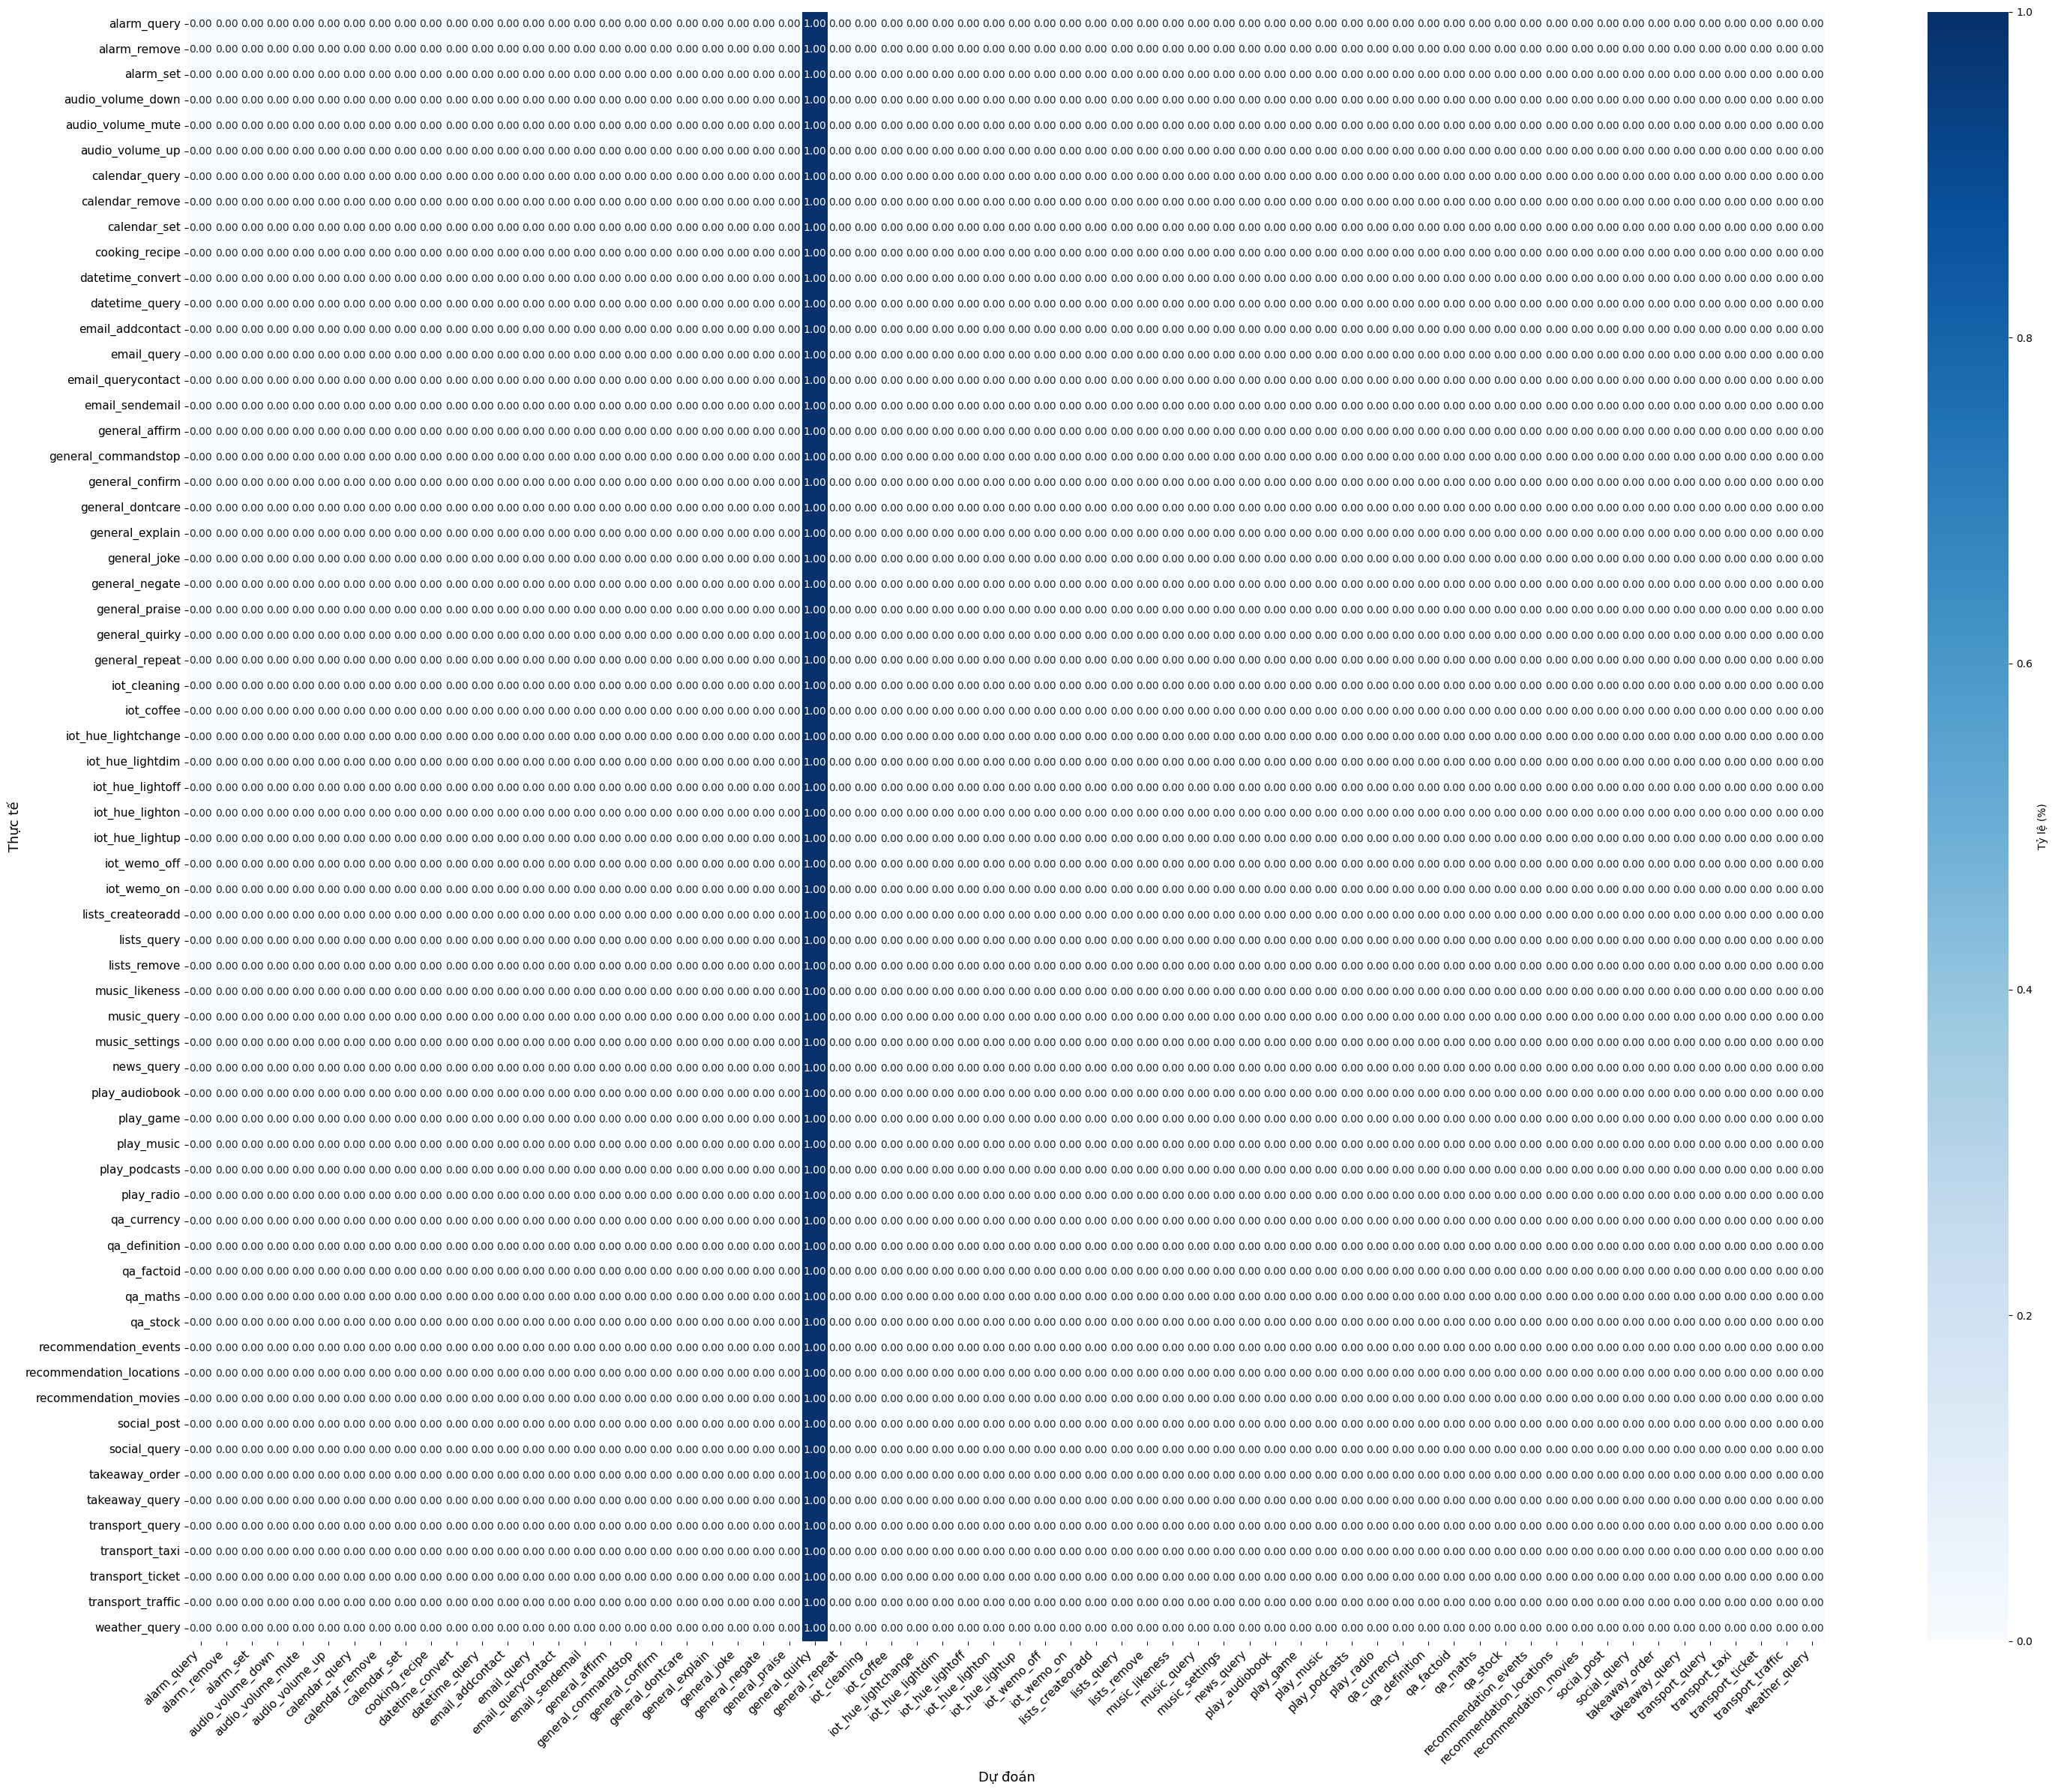

In [48]:
visualize_confusion_matrix(df_test['intent'], y_pred, label_enc.classes_)

# Thống kê kết quả

**Độ đo F1 và Loss**

| Pipeline | iot_hue_lighton | iot_wemo_on | music_settings | audio_volume_down | datetime_convert | email_addcontact | iot_wemo_off | Test Loss |
|---|-----|----|----|----|---|----|---|----|
| TF-IDF + Logistic Regression | 0.67 | 0.88 | 0.73 | 0.86 | 0.71 | 0.82 | 0.84 | 1.0502
| Word2Vec (Avg) + Dense | 0 | 0.60 | 0 | 0.33 | 0.50 | 0.76 | 0.61 | 1.9769
| Embedding (Pre-trained) + LSTM | 0 | 0.62 | 0 | 0.22 | 0 | 0 | 0.44 | 2.7085 |
| Embedding (Scratch) + LSTM | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 4.1236 |


# Test

In [50]:
test_data = [
    "can you remind me to not call my mom",
    "is it going to be sunny or rainy tomorrow",
    "find a flight from new york to london but not through paris"
]

In [53]:
test_lr = tfidf_lr_pipeline.predict(test_data)
for text, label in zip(test_data, test_lr):
    print(f"{text} -> {label_enc.classes_[label]}")

can you remind me to not call my mom -> calendar_set
is it going to be sunny or rainy tomorrow -> weather_query
find a flight from new york to london but not through paris -> general_negate


In [58]:
sentences = np.array([sentence_to_avg_vector(sentence, w2v_model) for sentence in test_data])

test_w2v_dense = np.argmax(model.predict(sentences), axis=1)
for text, label in zip(test_data, test_w2v_dense):
    print(f"{text} -> {label_enc.classes_[label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
can you remind me to not call my mom -> social_post
is it going to be sunny or rainy tomorrow -> weather_query
find a flight from new york to london but not through paris -> social_post


In [59]:
sen_sequences = tokenizer.texts_to_sequences(test_data)
sen_pad = pad_sequences(sen_sequences, maxlen=max_len, padding='post')

In [61]:
test_emb_pre_lstm = np.argmax(lstm_model_pretrained.predict(X_test_pad), axis=1)
for text, label in zip(test_data, test_emb_pre_lstm):
    print(f"{text} -> {label_enc.classes_[label]}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
can you remind me to not call my mom -> alarm_query
is it going to be sunny or rainy tomorrow -> alarm_query
find a flight from new york to london but not through paris -> alarm_set


In [62]:
test_emb_lstm = np.argmax(lstm_model_scratch.predict(X_test_pad), axis=1)
for text, label in zip(test_data, test_emb_lstm):
    print(f"{text} -> {label_enc.classes_[label]}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
can you remind me to not call my mom -> general_quirky
is it going to be sunny or rainy tomorrow -> general_quirky
find a flight from new york to london but not through paris -> general_quirky
